In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from examples.offline.utils import load_buffer_d4rl
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

No module named 'mjrl'
No module named 'flow'
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'dm_env'
No module named 'carla'
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/shimmy/registration.py", line 303, in register_gymnasium_envs
    _register_dm_control_envs()
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/shimmy/registration.py", line 63, in _register_dm_control_envs
    from shimmy.dm_control_compatibility import DmCont

In [2]:
device = "cuda"
learning_rate = 1e-3
batch_size = 64
epochs = 5
hidden_sizes = [128, 256, 128]

In [3]:
IDdata = load_buffer_d4rl("halfcheetah-medium-v2")

/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gym/envs/mujoco/mujoco_env.py:190: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile:   0%|          | 0/21 [00:00<?, ?it/s]

load datafile: 100%|██████████| 21/21 [00:01<00:00, 10.82it/s]


In [4]:
ODdata = load_buffer_d4rl("halfcheetah-random-v2")

load datafile:   0%|          | 0/9 [00:00<?, ?it/s]

load datafile: 100%|██████████| 9/9 [00:01<00:00,  4.73it/s]


In [5]:
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(MyModel, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_sizes[i], hidden_sizes[i+1])
            for i in range(len(hidden_sizes) - 1)
        ])
        self.output_layer = nn.Linear(hidden_sizes[-1], 1)  # 1 output for energy score
    
    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = torch.relu(hidden_layer(x))
        output = self.output_layer(x)
        return torch.sigmoid(output)

In [6]:
class MyData(Dataset):
    def __init__(self, IDobs, ODobs, device=device):
        self.IDobs = torch.from_numpy(IDobs)
        self.ODobs = torch.from_numpy(ODobs)
        self.X = torch.concatenate((self.IDobs, self.ODobs)).to(device)
        self.y = torch.concatenate((torch.ones(len(self.IDobs)), torch.zeros(len(self.ODobs)))).unsqueeze(-1).to(device)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [7]:
train_ID, test_ID = train_test_split(IDdata.obs, test_size=0.2)
train_ID, val_ID = train_test_split(train_ID, test_size=0.2)
train_OD, test_OD = train_test_split(ODdata.obs, test_size=0.2)
train_OD, val_OD = train_test_split(train_OD, test_size=0.2)

In [8]:
train_data = MyData(train_ID, train_OD)
val_data = MyData(val_ID, val_OD)
test_data = MyData(test_ID, test_OD)

In [9]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [10]:
train_features, train_labels = next(iter(train_dataloader))

In [11]:
input_size = list(train_features[0].shape)[0]

In [12]:
model = MyModel(input_size, hidden_sizes).to(device)
print(f"Model structure: {model}\n\n")

Model structure: MyModel(
  (input_layer): Linear(in_features=17, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
  )
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)




In [13]:
loss_fn = nn.BCELoss()

In [14]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer, val_dataloader=None, epochs=1):
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for X, y in dataloader:
            optimizer.zero_grad()  # Zero gradients before forward pass
            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(dataloader)

        if val_dataloader:
            model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for X_val, y_val in val_dataloader:
                    pred_val = model(X_val)
                    val_loss = loss_fn(pred_val, y_val).item()
                    total_val_loss += val_loss

            avg_val_loss = total_val_loss / len(val_dataloader)
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    return avg_train_loss, avg_val_loss

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [16]:
train_losses, val_losses = train_loop(train_dataloader, model, loss_fn, optimizer, val_dataloader, epochs=10)

loss: 0.683326  [   64/1278720]
Validation Loss: 0.690828
loss: 0.667142  [ 6464/1278720]
Validation Loss: 0.691787
loss: 0.651765  [12864/1278720]
Validation Loss: 0.649237
loss: 0.616587  [19264/1278720]
Validation Loss: 0.658497
loss: 0.631543  [25664/1278720]
Validation Loss: 0.647311
loss: 0.630650  [32064/1278720]
Validation Loss: 0.608817
loss: 0.600752  [38464/1278720]
Validation Loss: 0.586184
loss: 0.591708  [44864/1278720]
Validation Loss: 0.576557
loss: 0.557294  [51264/1278720]
Validation Loss: 0.555712
loss: 0.569211  [57664/1278720]
Validation Loss: 0.532264
loss: 0.527028  [64064/1278720]
Validation Loss: 0.499623
loss: 0.511635  [70464/1278720]
Validation Loss: 0.493605
loss: 0.481784  [76864/1278720]
Validation Loss: 0.512860
loss: 0.437001  [83264/1278720]
Validation Loss: 0.430846
loss: 0.417916  [89664/1278720]
Validation Loss: 0.434237
loss: 0.366937  [96064/1278720]
Validation Loss: 0.434463
loss: 0.364762  [102464/1278720]
Validation Loss: 0.363198
loss: 0.33106

KeyboardInterrupt: 

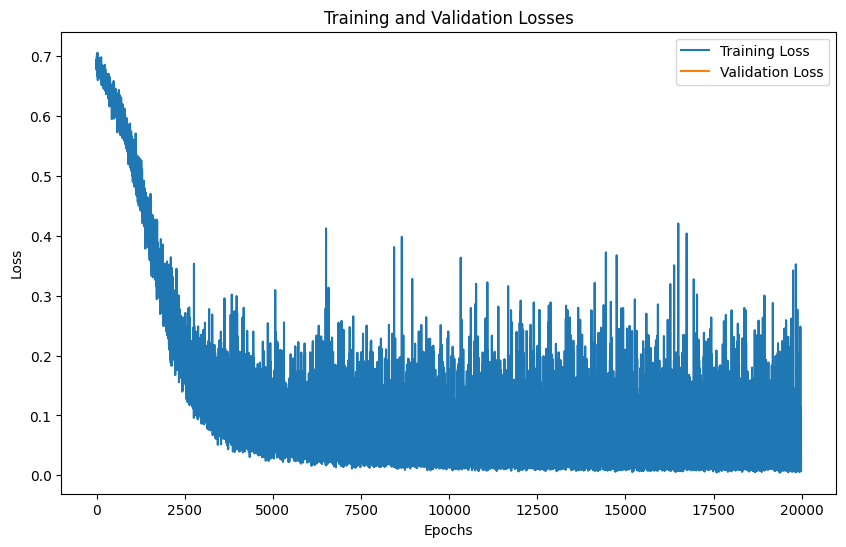

In [17]:
plot_losses(train_losses, val_losses)

In [20]:
with torch.no_grad():
    test_pred = model(test_dataloader.dataset.X).round().cpu()
    test_labels = test_dataloader.dataset.y.cpu()

cm = confusion_matrix(test_labels, test_pred)

In [21]:
cm

array([[199438,    362],
       [  4230, 195570]])